## Load dataset

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install -q kaggle

ERROR: Could not install packages due to an OSError: [WinError 2] A rendszer nem találja a megadott fájlt: 'C:\\Python311\\Scripts\\kaggle.exe' -> 'C:\\Python311\\Scripts\\kaggle.exe.deleteme'


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# download api token from: https://www.kaggle.com/settings -> and upload here:
# from google.colab import files

# files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nguyentuannguyen/optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
train_dataset = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')
train_dataset.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/optiver-trading-at-the-close/train.csv'

## Local

In [8]:
train_dataset = pd.read_csv('content/optiver-trading-at-the-close/train.csv')
train_dataset.shape

(5237980, 17)

## Feature selection and engineering

In [9]:
# List of columns to convert to float32
columns_to_convert = ['reference_price', 'matched_size', 'far_price', 'near_price',
                      'bid_price', 'bid_size', 'ask_price', 'ask_size',
                      'wap', 'target', 'imbalance_size']

# Convert the columns to float32
train_dataset[columns_to_convert] = train_dataset[columns_to_convert].astype('float32')
train_dataset.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float32
imbalance_buy_sell_flag      int64
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int64
row_id                      object
dtype: object

In [10]:
from sklearn.preprocessing import QuantileTransformer
# Applying Quantile Transformation to follow a normal distribution

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
train_dataset['Quantile_imbalance_size'] = quantile_transformer.fit_transform(train_dataset['imbalance_size'].values.reshape(-1, 1)).flatten()
train_dataset['Quantile_far_price'] = quantile_transformer.fit_transform(train_dataset['far_price'].values.reshape(-1, 1)).flatten()

# bid_size
train_dataset['Quantile_bid_size'] = quantile_transformer.fit_transform(train_dataset['bid_size'].values.reshape(-1, 1)).flatten()

# ask_size
train_dataset['Quantile_ask_size'] = quantile_transformer.fit_transform(train_dataset['ask_size'].values.reshape(-1, 1)).flatten()

In [11]:
# original features
features = ['imbalance_size', 'far_price', 'bid_size', 'ask_size']

# drop features
train_dataset = train_dataset.drop(features, axis=1)

In [12]:
def inspect_columns(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
#         'null_num': df.isnull().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
#         '1st_row': df.iloc[0],
#         'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(train_dataset)

,unique,cardinality,with_null,null_pct,dtype
stock_id,False,200,False,0.00,int64
date_id,False,481,False,0.00,int64
seconds_in_bucket,False,55,False,0.00,int64
imbalance_buy_sell_flag,False,3,False,0.00,int64
reference_price,False,28741,True,0.00,float32
matched_size,False,2875627,True,0.00,float32
near_price,False,84625,True,54.55,float32
bid_price,False,28313,True,0.00,float32
ask_price,False,28266,True,0.00,float32
wap,False,31506,True,0.00,float32


In [13]:
train_dataset['volume'] = train_dataset['Quantile_ask_size'] + train_dataset['Quantile_bid_size']
train_dataset['volume_norm'] = (train_dataset['volume'] - train_dataset['volume'].mean()) / train_dataset['volume'].std()

In [14]:
df_train = train_dataset.copy()

def drop_missing_values(df):
    # drop the missing values of wap
    df = df.dropna(subset=['wap'])
    return df
# drop the missing values of wap
df_train = drop_missing_values(df_train)
df_train.shape

(5237760, 19)

##### keep only the features selected in "trading_at_the_close_visualisation"
 ['stock_id' 'date_id' 'seconds_in_bucket' 'imbalance_size'
 'reference_price' 'matched_size' 'far_price' 'near_price' 'bid_price'
 'bid_size' 'ask_price' 'ask_size' 'wap' 'row_id' 'date_id_week'
 'date_id_seconds' 'total_volume' 'near_far_ratio' 'near_far_imbalance'
 'ask_mat_ratio' 'bid_mat_ratio' 'ask_ref_ratio'
 'imbalance_continuous_ratio' 'ask_wap_diff' 'all_prices_skew'
 'all_sizes_skew' 'all_prices_kurt' 'all_sizes_kurt'
 'imbalance_buy_sell_flag_cumsum' 'imbalance_buy_sell_flag_0'
 'imbalance_buy_sell_flag_1']


In [15]:
%%time

def calc_feature_single_stock(df):
    # Feature of each stock at different time point
    # date_id
    df["date_id_week"] = df["date_id"] % 5  # Day of the week
    df["date_id_seconds"] = df["seconds_in_bucket"] % 60  # Seconds
   
    
    # ask bid 
    df['spread'] = df['ask_price'] - df['bid_price']
   
    df['mid_price'] = (df['bid_price'] + df['ask_price'])/2
    # product of imbalance size and bid-ask spread
    df["price_pressure"] = df["Quantile_imbalance_size"] * (df["spread"])
    
    # near_price far_price
    df['near_far_ratio'] = df['near_price'] / df['Quantile_far_price']
    df['near_far_imbalance'] = (df['Quantile_far_price'] - df['near_price']) / (df['Quantile_far_price'] + df['near_price'])
   
    
    #The ratio between ask/bid and matched sizes provides insights into market liquidity and order flow:
    # A high ask-to-matched ratio suggests that there are more sellers than buyers at a given price level, 
    # potentially indicating resistance to upward price movement.
    # Conversely, a low ratio implies stronger buying interest and potential support for price increases.
    
    df['ask_mat_ratio'] = df['Quantile_ask_size']/df['matched_size']
    df['bid_mat_ratio'] = df['Quantile_bid_size']/df['matched_size']
    
    # The ratio between the ask/bid price and the reference price provides insights into market sentiment:
    # - Above 1: If the ask/bid price is higher than the reference price, it suggests bullish sentiment. Sellers are demanding a premium.
    # - Below 1: If the ask/bid price is lower than the reference price, it indicates bearish sentiment. Buyers are getting a discount.
    df['ask_ref_ratio'] = df['ask_price']/df['reference_price']
    # imbalance_size matched_size
    df['auction_volume'] = df['Quantile_imbalance_size'] + df['matched_size']
    # relative imbalance between matched and total size
    df["imbalance_ratio"] = (df["Quantile_imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["Quantile_imbalance_size"])
    # cross term 
    df["imbalance_continuous_ratio"] = df['Quantile_imbalance_size'] / df["volume"]
    # the overall level of buying and selling in financial markets
    df['market_activity'] = df['Quantile_bid_size'] * df['bid_price'] + df['Quantile_ask_size'] * df['ask_price']
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['ask_wap_diff'] = df['ask_price'] - df['wap']
    # Accumulative features
    df['imbalance_buy_sell_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['imbalance_buy_sell_flag'].cumsum()
    
    # statistical features at different time point
    prices = ["reference_price", "Quantile_far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "Quantile_bid_size", "Quantile_ask_size", "Quantile_imbalance_size"]
    for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
            

    return df

df_train = calc_feature_single_stock(df_train)
df_train.tail()


CPU times: total: 2.56 s
Wall time: 10.7 s


,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,matched_size,near_price,bid_price,ask_price,wap,...,ask_wap_diff,imbalance_buy_sell_flag_cumsum,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt
5237975,195,480,540,-1,1.000317,28280362.0,0.999734,1.000317,1.000434,1.000328,...,0.000106,-54,0.830386,7070091.00,0.416020,14140180.0,-2.449488,2.0,5.999992,4.0
5237976,196,480,540,-1,1.000643,9187699.0,1.000386,1.000643,1.000900,1.000819,...,0.000081,-55,0.847850,2296925.50,0.374351,4593849.0,-2.449489,2.0,5.999995,4.0
5237977,197,480,540,0,0.995789,12725436.0,0.995789,0.995789,0.995883,0.995797,...,0.000086,-54,0.705909,3181358.25,0.710108,6362718.5,-2.449490,2.0,6.000000,4.0
5237978,198,480,540,1,0.999210,94773272.0,0.999210,0.998970,0.999210,0.999008,...,0.000202,28,0.809469,23693318.00,0.464552,47386636.0,-2.449490,2.0,5.999999,4.0
5237979,199,480,540,-1,1.002129,24073678.0,1.001494,1.002129,1.002447,1.002274,...,0.000173,-35,0.882249,6018420.50,0.293562,12036838.0,-2.449483,2.0,5.999975,4.0


In [16]:
# def calculate_vwap(df):
#     df['vwap_reference_price'] = (df['wap'] * df['reference_price']).cumsum() / df['volume'].cumsum()
#     return df
# df_train = calculate_vwap(df_train)
# df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,matched_size,near_price,bid_price,ask_price,wap,...,imbalance_buy_sell_flag_cumsum,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,vwap_reference_price
0,0,0,0,1,0.999812,13380277.00,NaN,0.999812,1.000026,1.0,...,1,0.999913,3.345070e+06,0.000117,6.690138e+06,0.042897,2.0,0.000000,4.0,9.589178
1,1,0,0,-1,0.999896,1642214.25,NaN,0.999896,1.000660,1.0,...,-1,1.000113,4.105531e+05,0.000368,8.211074e+05,1.897504,2.0,3.617163,4.0,-1.921946
2,2,0,0,-1,0.999561,1819368.00,NaN,0.999403,1.000298,1.0,...,-1,0.999816,4.548419e+05,0.000409,9.096841e+05,0.311287,2.0,-2.953897,4.0,-3.830244
3,3,0,0,-1,1.000171,18389746.00,NaN,0.999999,1.000214,1.0,...,-1,1.000096,4.597437e+06,0.000113,9.194873e+06,0.124467,2.0,0.000000,4.0,9.279469
4,4,0,0,-1,0.999532,17860614.00,NaN,0.999394,1.000016,1.0,...,-1,0.999735,4.465153e+06,0.000320,8.930307e+06,-0.156620,2.0,-5.078881,4.0,-3.027896


In [17]:
df_train['rolling_std_reference_price'] = df_train.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(window=54).std())

In [18]:
# make dummy from imbalance_buy_sell_flag and get dummy columns
dummy_cols_list = ['imbalance_buy_sell_flag']
dummy_names = []

for col in dummy_cols_list:
    dummy_df = pd.get_dummies(df_train.loc[:, col], prefix=col, drop_first=True)
    dummy_names += dummy_df.columns.tolist()
    # drop original column
    df_train = df_train.drop(col, axis=1)
    df_train = pd.concat([df_train, dummy_df], axis=1)

In [19]:

# drop these columns
df_train = df_train.drop(['all_sizes_std','all_prices_std','all_sizes_mean','market_activity','mid_price'], axis=1)
# drop: near_far_mid, auction_volume,all_prices_mean
df_train = df_train.drop([ 'auction_volume','all_prices_mean'], axis=1)


# drop: time_id
df_train = df_train.drop(['time_id'], axis=1)

The result of feature selection (trading_at_the_close_visualisation_1.ipynb)

In [20]:
selected_features = ['stock_id','target','imbalance_buy_sell_flag_0','imbalance_buy_sell_flag_1', 'rolling_std_reference_price','date_id','seconds_in_bucket', 'ask_ref_ratio', 'Quantile_bid_size', 'Quantile_ask_size',  'ask_wap_diff', 'spread']

# keep only the selected features
df_train = df_train[selected_features]

In [21]:
df_train

,stock_id,target,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1,rolling_std_reference_price,date_id,seconds_in_bucket,ask_ref_ratio,Quantile_bid_size,Quantile_ask_size,ask_wap_diff,spread
0,0,-3.029704,False,True,NaN,0,0,1.000214,0.739395,-0.635130,0.000026,0.000214
1,1,-5.519986,False,False,NaN,0,0,1.000764,-1.068202,-0.076523,0.000660,0.000764
2,2,-8.389950,False,False,NaN,0,0,1.000737,0.391064,-0.133653,0.000298,0.000895
3,3,-4.010201,False,False,NaN,0,0,1.000043,-1.200443,2.414491,0.000214,0.000215
4,4,-7.349849,False,False,NaN,0,0,1.000484,-0.196919,-1.885052,0.000016,0.000622
...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,2.310276,False,False,0.000270,480,540,1.000117,0.266118,2.022891,0.000106,0.000117
5237976,196,-8.220077,False,False,0.000518,480,540,1.000257,1.651024,1.058055,0.000081,0.000257
5237977,197,1.169443,True,False,0.001755,480,540,1.000094,-0.185484,1.539343,0.000086,0.000094
5237978,198,-1.540184,False,True,0.000460,480,540,1.000000,1.279195,2.784187,0.000202,0.000240


# Load from preprocessed file

In [22]:
# # load preprocess data
# df_train = pd.read_csv('data/optiver-trading-at-the-close/train_preprocess_short.csv')

# selected_features = ['stock_id','target','imbalance_buy_sell_flag_0','imbalance_buy_sell_flag_1', 'rolling_std_matched_size','date_id','seconds_in_bucket', 'ask_ref_ratio', 'Quantile_bid_size', 'Quantile_ask_size',  'ask_wap_diff', 'spread']

# # keep only the selected features
# df_train = df_train[selected_features]

FileNotFoundError: [Errno 2] No such file or directory: 'data/optiver-trading-at-the-close/train_preprocess_short.csv'

# LSTM

In [23]:
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tensorflow as tf
import random as python_random
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
from xgboost import XGBRegressor, plot_importance

In [24]:
SEED = 42
N_LAGS = 55
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 10
PATIENCE = 25
DROPOUT = 0.5
LEARNING_RATE = 1e-4
SPLIT_DAY = 390
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55
RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

DATA FORMATTER

In [25]:

def windowed_dataset(dataset, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
      dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset


def build_features(df):

    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
                values='target',
                index=['date_id', 'seconds_in_bucket'],
                columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

In [41]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, GRU, SimpleRNN, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Bidirectional

build_features(df_train)

def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

def build_model_2(dropout=DROPOUT):
    model = Sequential()
    #model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Embedding(input_dim=N_STOCKS,output_dim=64))
    model.add(GRU(256, return_sequences=True))
    model.add(Conv1D(64, 2))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(128))
    model.add(Conv1D(128, 3))
    model.add(MaxPooling1D(2))
    model.add(Dense(64, ))
    model.add(LSTM(256, ))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(64, ))
    model.add(Dropout(0.2))
    model.add(Dense(32, ))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

In [42]:
if RUN_TRAINING:

  split = df_train['date_id'] > SPLIT_DAY
  df_train_ = df_train[~split]
  df_valid = df_train[split]

  df_train_features = build_features(df_train_)
  df_valid_features = build_features(df_valid)

  scaler = StandardScaler()
  train_features = scaler.fit_transform(df_train_features)
  valid_features = scaler.transform(df_valid_features)

  train_dataset = windowed_dataset(train_features)
  valid_dataset = windowed_dataset(valid_features, shuffle=False)

  #model = build_model()
  model = build_model_2()

  early_stopping = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience=PATIENCE,
                    restore_best_weights=True,
                    verbose=True)

  history = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=[early_stopping],
                      verbose=True)

  ## Evaluate ##
  y_pred = model.predict(valid_dataset)

  y_pred = scaler.inverse_transform(y_pred)
  y_true = df_valid_features[N_LAGS:]

  mae = mean_absolute_error(y_true, y_pred)
  print(f"MAE score: {mae}")

ValueError: Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 256)

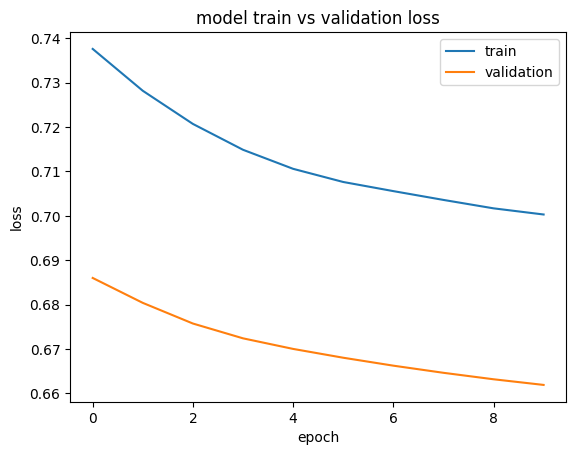

In [28]:

# Plots ##
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import itertools

SEED = 42
N_LAGS = 55
BUFFER_SIZE = 100000
SPLIT_DAY = 390
N_STOCKS = 200
N_SECONDS = 55
RUN_TRAINING = True
PATIENCE = 25
EPOCHS = 10

# Hyperparameters
param_grid = {
    'N_LAGS': [55, 60, 65],
    'BATCH_SIZE': [32, 64],
    'DROPOUT': [0.3, 0.5, 0.7],
    'LEARNING_RATE': [1e-4, 1e-3],
    'LSTM_UNITS': [25, 50]
}

best_mae = float('inf')
best_hyperparameters = None

def windowed_dataset(dataset, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
        values='target',
        index=['date_id', 'seconds_in_bucket'],
        columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

if RUN_TRAINING:
    split = df_train['date_id'] > SPLIT_DAY
    df_train_ = df_train[~split]
    df_valid = df_train[split]

    df_train_features = build_features(df_train_)
    df_valid_features = build_features(df_valid)

    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train_features)
    valid_features = scaler.transform(df_valid_features)

    train_dataset = windowed_dataset(train_features)
    valid_dataset = windowed_dataset(valid_features, shuffle=False)

    for params in itertools.product(*param_grid.values()):
        hyperparameters = dict(zip(param_grid.keys(), params))

        def build_model(dropout=hyperparameters['DROPOUT'], lstm_units=hyperparameters['LSTM_UNITS']):
            model = Sequential()
            model.add(Input(shape=(hyperparameters['N_LAGS'], N_STOCKS)))
            model.add(Dropout(dropout))
            model.add(LSTM(lstm_units, return_sequences=False))
            model.add(Dropout(dropout))
            model.add(Dense(N_STOCKS))
            model.compile(loss='mae',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters['LEARNING_RATE']))
            return model

        model = build_model()

        early_stopping = EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=PATIENCE,
                                       restore_best_weights=True,
                                       verbose=True)

        history = model.fit(train_dataset,
                            validation_data=valid_dataset,
                            epochs=EPOCHS,
                            batch_size=hyperparameters['BATCH_SIZE'],
                            callbacks=[early_stopping],
                            verbose=True)

        y_pred = model.predict(valid_dataset)

        y_pred = scaler.inverse_transform(y_pred)
        y_true = df_valid_features[N_LAGS:]

        mae = mean_absolute_error(y_true, y_pred)
        print(f"MAE score for hyperparameters {hyperparameters}: {mae}")

        if mae < best_mae:
            best_mae = mae
            best_hyperparameters = hyperparameters

    print(f"Best hyperparameters: {best_hyperparameters}, Best MAE: {best_mae}")


Epoch 1/10
671/671 [==============================] - 144s 206ms/step - loss: 0.7316 - val_loss: 0.6849
Epoch 2/10
671/671 [==============================] - 140s 205ms/step - loss: 0.7218 - val_loss: 0.6779
Epoch 3/10
671/671 [==============================] - 139s 204ms/step - loss: 0.7139 - val_loss: 0.6729
Epoch 4/10
671/671 [==============================] - 140s 206ms/step - loss: 0.7082 - val_loss: 0.6696
Epoch 5/10
671/671 [==============================] - 140s 206ms/step - loss: 0.7040 - val_loss: 0.6667
Epoch 6/10
671/671 [==============================] - 140s 206ms/step - loss: 0.7005 - val_loss: 0.6642
Epoch 7/10
671/671 [==============================] - 139s 205ms/step - loss: 0.6975 - val_loss: 0.6619
Epoch 8/10
671/671 [==============================] - 138s 204ms/step - loss: 0.6952 - val_loss: 0.6600
Epoch 9/10
671/671 [==============================] - 145s 213ms/step - loss: 0.6931 - val_loss: 0.6584
Epoch 10/10
153/153 [==============================] - 2s 11ms/s

KeyboardInterrupt: 

# Best Training parameters
Epoch 1/10
671/671 [==============================] - 50s 69ms/step - loss: 0.7005 - val_loss: 0.6466
Epoch 2/10
671/671 [==============================] - 39s 55ms/step - loss: 0.6756 - val_loss: 0.6352
Epoch 3/10
671/671 [==============================] - 51s 73ms/step - loss: 0.6691 - val_loss: 0.6302
Epoch 4/10
671/671 [==============================] - 65s 93ms/step - loss: 0.6661 - val_loss: 0.6276
Epoch 5/10
671/671 [==============================] - 43s 60ms/step - loss: 0.6641 - val_loss: 0.6256
Epoch 6/10
671/671 [==============================] - 35s 49ms/step - loss: 0.6626 - val_loss: 0.6250
Epoch 7/10
671/671 [==============================] - 40s 57ms/step - loss: 0.6613 - val_loss: 0.6241
Epoch 8/10
671/671 [==============================] - 39s 55ms/step - loss: 0.6605 - val_loss: 0.6231
Epoch 9/10
671/671 [==============================] - 48s 68ms/step - loss: 0.6598 - val_loss: 0.6229
Epoch 10/10
671/671 [==============================] - 36s 50ms/step - loss: 0.6594 - val_loss: 0.6221
153/153 [==============================] - 2s 8ms/step
MAE score for hyperparameters {'N_LAGS': 60, 'BATCH_SIZE': 32, 'DROPOUT': 0.3, 'LEARNING_RATE': 0.001, 'LSTM_UNITS': 50}: 5.548815727233887


In [ ]:
SEED = 42
N_LAGS = 60
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 10
PATIENCE = 25
DROPOUT = 0.3
LEARNING_RATE = 1e-3
SPLIT_DAY = 390
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55
RUN_TRAINING = True
# RUN_FOR_SUBMISSION = True

In [ ]:
build_features(df_train)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010201,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,...,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280210,-8.010268,-0.780225,-0.640154,...,4.210472,2.599955,-15.599728,-1.749992,-9.030104,-1.320243,-3.259778,-4.410148,-1.419783,0.000000
2,4.220009,-6.459951,-6.380081,-2.030134,-0.690222,1.009703,2.930164,-12.069941,-4.119873,-3.250241,...,5.379915,-5.970001,-12.710094,2.160072,-9.999871,5.890131,-0.029802,-6.819963,2.599955,0.000000
3,5.450249,-5.149841,-5.819798,1.130104,-2.589822,-3.089905,0.560284,-6.909966,-1.090169,-6.759763,...,-3.269911,1.300573,-16.660095,4.090071,-9.340048,7.020235,1.549721,1.690388,3.010035,0.000000
4,3.169775,-6.750226,-0.280142,-2.350211,-4.900098,-2.070069,2.199411,-1.209974,-3.100038,-8.199811,...,-2.009869,-0.969768,-9.229779,5.700588,-11.489987,4.500151,-1.350045,-1.929998,4.669428,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,3.999472,2.850294,-4.450083,1.720190,1.939535,-4.569888,-0.630021,-1.729727,-0.680089,3.540516,...,-4.730225,-7.420182,2.959967,-2.359748,-0.650287,3.190041,-1.659989,-0.690222,-2.700090,-7.209778
26451,3.190041,3.169775,-5.559921,4.669428,2.139807,1.679659,-0.360012,-3.240108,2.609491,1.679659,...,-3.340244,-3.479719,1.419783,-1.069903,2.319813,3.770590,-3.039837,-3.299713,-2.070069,-9.750128
26452,-0.169873,5.689859,-5.310178,5.639791,1.660585,2.110004,-1.000166,-4.529953,5.409718,0.350475,...,-1.549721,-1.289845,-0.140071,-1.929998,4.609823,1.449585,-6.319880,-1.999736,-2.239943,3.629923
26453,3.110170,10.650158,-5.239844,5.229712,0.300407,-2.030134,-1.180172,-1.310110,3.240108,0.220537,...,-1.440048,-0.299811,-2.120137,-1.350045,3.110170,4.019737,-7.349849,-3.259778,-3.160238,4.760027


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import itertools

SEED = 42
N_LAGS = 60
BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 25
PATIENCE = 25
DROPOUT = 0.3
LEARNING_RATE = 1e-3
SPLIT_DAY = 390
N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55
RUN_TRAINING = True


best_mae = float('inf')
best_hyperparameters = None

def windowed_dataset(dataset, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0)
    df_full = df_full.reset_index()

    df_pivoted = df_full.pivot_table(
        values='target',
        index=['date_id', 'seconds_in_bucket'],
        columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

if RUN_TRAINING:

  split = df_train['date_id'] > SPLIT_DAY
  df_train_ = df_train[~split]
  df_valid = df_train[split]

  df_train_features = build_features(df_train_)
  df_valid_features = build_features(df_valid)

  scaler = StandardScaler()
  train_features = scaler.fit_transform(df_train_features)
  valid_features = scaler.transform(df_valid_features)

  train_dataset = windowed_dataset(train_features)
  valid_dataset = windowed_dataset(valid_features, shuffle=False)

  model = build_model()

  early_stopping = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience=PATIENCE,
                    restore_best_weights=True,
                    verbose=True)

  history = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=[early_stopping],
                      verbose=True)

  ## Evaluate ##
  y_pred = model.predict(valid_dataset)

  y_pred = scaler.inverse_transform(y_pred)
  y_true = df_valid_features[N_LAGS:]

  mae = mean_absolute_error(y_true, y_pred)
  print(f"MAE score: {mae}")

Epoch 1/10
671/671 [==============================] - 87s 103ms/step - loss: 0.7065 - val_loss: 0.6570
Epoch 2/10
671/671 [==============================] - 67s 87ms/step - loss: 0.6877 - val_loss: 0.6497
Epoch 3/10
671/671 [==============================] - 67s 86ms/step - loss: 0.6833 - val_loss: 0.6469
Epoch 4/10
671/671 [==============================] - 68s 86ms/step - loss: 0.6807 - val_loss: 0.6447
Epoch 5/10
671/671 [==============================] - 68s 87ms/step - loss: 0.6792 - val_loss: 0.6437
Epoch 6/10
671/671 [==============================] - 68s 86ms/step - loss: 0.6779 - val_loss: 0.6425
Epoch 7/10
671/671 [==============================] - 68s 87ms/step - loss: 0.6771 - val_loss: 0.6417
Epoch 8/10
671/671 [==============================] - 67s 85ms/step - loss: 0.6761 - val_loss: 0.6410
Epoch 9/10
671/671 [==============================] - 68s 87ms/step - loss: 0.6753 - val_loss: 0.6402
Epoch 10/10
153/153 [==============================] - 4s 23ms/step
MAE score: 5.

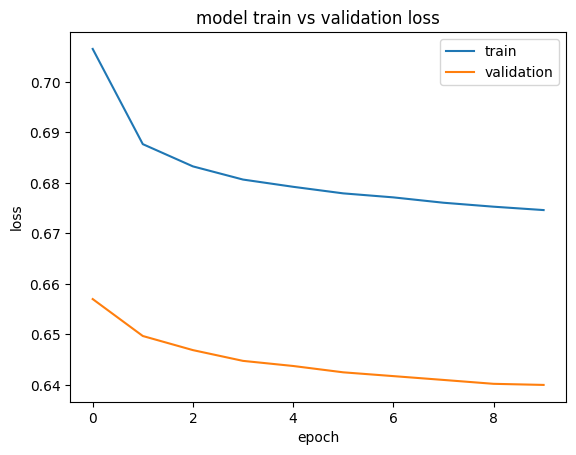

In [ ]:
# Plots ##
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()